In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

# Loading Model

In [4]:
path = '/data/models/ltune/qlsm_tuner_v2/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = config['lsm']['design']
design_type

'QLSM'

In [5]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_21.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [6]:
torchinfo.summary(model, (1, len(config["ltune"]["input_features"])), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QLSMTuner                                [1, 61]                   --
├─BatchNorm1d: 1-1                       [1, 9]                    18
├─Linear: 1-2                            [1, 32]                   320
├─ReLU: 1-3                              [1, 32]                   --
├─Dropout: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 64]                   2,112
├─ReLU: 1-6                              [1, 64]                   --
├─Sequential: 1-7                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─Linear: 2-2                       [1, 64]                   4,160
│    └─Linear: 2-3                       [1, 64]                   4,160
├─Linear: 1-8                            [1, 1]                    65
├─Linear: 1-9                            [1, 30]                   1,950

# Util Module    

In [7]:
ltune_util = LTuneEvalUtil(config, model, design_type)

In [8]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
out, design
# system

(tensor([[3.1729, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CatBackward0>),
 LSMDesign(h=3.1728763580322266, T=9, policy=<Policy.QFixed: 3>, Q=2, Y=1.0, Z=1.0, K=[]))

# Training Loss

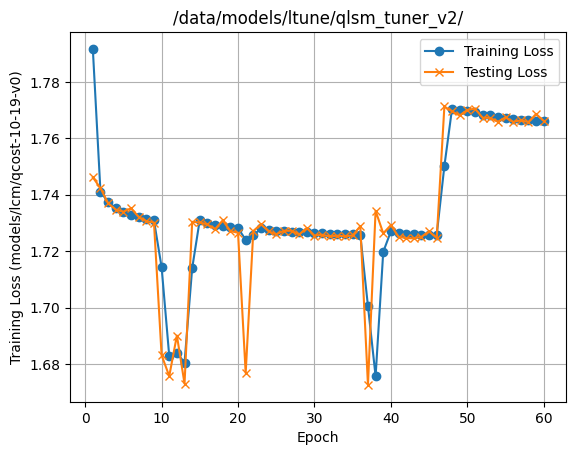

In [9]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[1:60]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

In [10]:
losses.idxmin()

epoch          1
train_loss    38
test_loss     37
dtype: int64

In [12]:
# def eval_lcm_direct(model_out, system, z0, z1, q, w):
#     label = torch.Tensor([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N]).view(1, -1)
#     inputs = torch.concat([label, model_out], dim=-1)
#     with torch.no_grad():
#         pred = loss_model(inputs)
#         pred = pred.sum().item()
#     return pred

# Evaluation

In [13]:
np.random.seed(0)
num_samples = 5000
default_sys = System()
table = []
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval()
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']

In [17]:
wl_cols = ['z0', 'z1', 'q', 'w']
stune_cols = ['stune_h', 'stune_T', 'stune_Q']
ltune_cols = ['ltune_h', 'ltune_T', 'ltune_Q']
cost_cols = ['stune_cost', 'stune_loss', 'ltune_cost', 'ltune_loss', 'ltune_loss_direct']
delta_cols = ['delta_cost', 'delta_loss']
cols = wl_cols + stune_cols + ltune_cols + cost_cols + delta_cols
table[table.stune_T == 30].sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,stune_h,stune_T,stune_Q,ltune_h,ltune_T,ltune_Q,stune_cost,stune_loss,ltune_cost,ltune_loss,ltune_loss_direct,delta_cost,delta_loss
4440,0.242,0.012,0.731,0.015,4.510384e+00,30,1,2.528115,21,2,1.051759,1.133485,2.274427,2.329768,1.188015,-1.162499,-1.055403
4365,0.780,0.003,0.205,0.012,7.423670e+00,30,1,6.161737,21,2,0.374569,0.400960,0.808621,0.851522,0.410271,-1.158806,-1.123705
4755,0.244,0.098,0.637,0.021,4.993524e+00,30,1,2.550462,21,2,0.966636,1.021995,2.050671,2.018957,1.068014,-1.121451,-0.975505
724,0.256,0.001,0.725,0.018,3.102988e+00,30,1,2.451200,21,2,1.257330,1.317249,2.663774,2.686950,1.417244,-1.118597,-1.039820
2929,0.099,0.150,0.746,0.005,2.258137e+00,30,1,1.631323,21,2,1.519336,1.635483,3.200649,3.325828,1.780490,-1.106611,-1.033545
4489,0.876,0.005,0.112,0.007,7.503766e+00,30,1,6.591328,21,2,0.256472,0.280543,0.539055,0.448770,0.294669,-1.101812,-0.599645
487,0.294,0.058,0.573,0.075,5.356322e+00,30,1,3.104581,21,2,1.004345,1.011786,2.100540,2.085787,1.064762,-1.091454,-1.061491
2516,0.725,0.005,0.253,0.017,6.663054e+00,30,1,5.975841,21,2,0.482561,0.435195,1.004397,1.085834,0.468914,-1.081390,-1.495050
1251,0.003,0.073,0.878,0.046,2.288178e-13,30,1,0.839262,21,2,1.341183,1.492403,2.781251,2.980104,1.593740,-1.073730,-0.996850
1413,0.200,0.048,0.581,0.171,3.279693e+00,30,1,2.394634,21,2,0.998090,0.966036,2.069168,2.128173,1.032585,-1.073127,-1.202996


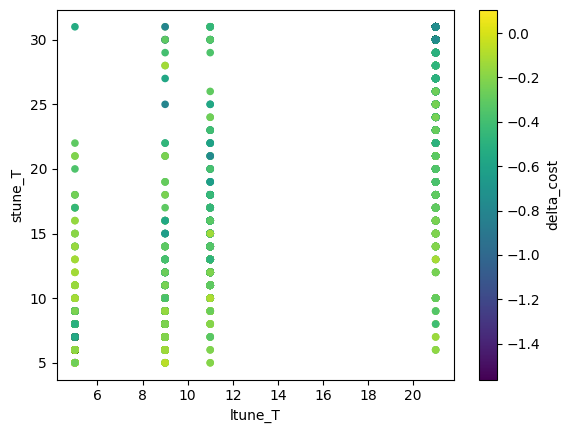

In [18]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

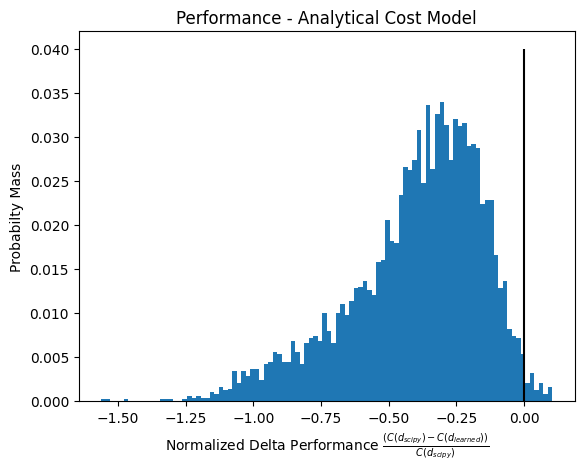

In [19]:
fig, ax = plt.subplots()
data = table['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - Analytical Cost Model')
ax.vlines(x=0, ymin=0, ymax=0.04, color='black')
# ax.legend()
plt.show()

## Learned Cost Model

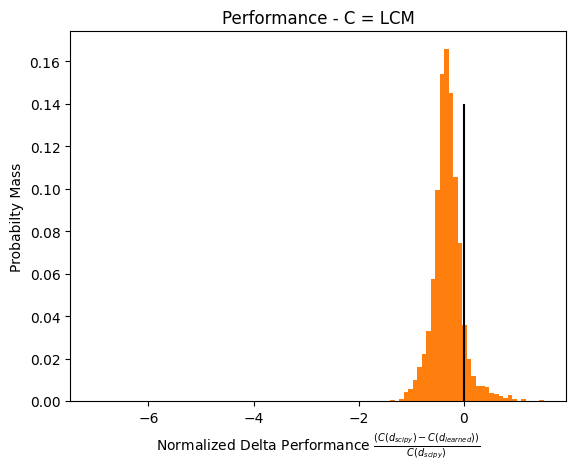

In [20]:
fig, ax = plt.subplots()
data = table['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - C = LCM')
ax.vlines(x=0, ymin=0, ymax=0.14, color='black')
plt.show()

## Difference in ACM and LCM

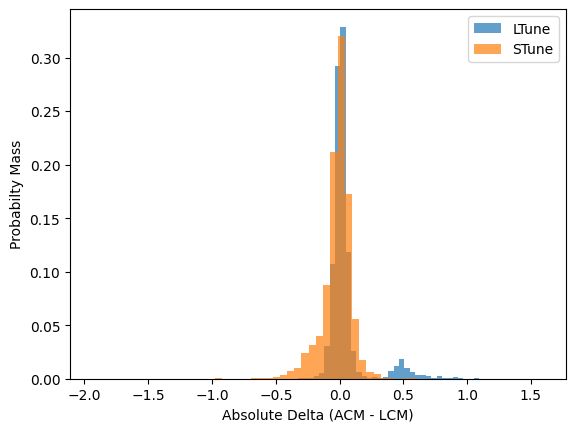

In [21]:
fig, ax = plt.subplots()
ldata = table['ltune_diff']
sdata = table['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [22]:
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [23]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

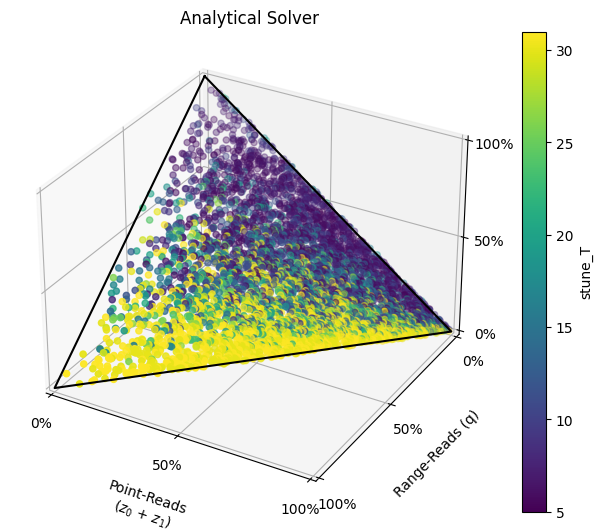

In [24]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
ax.set_title('Analytical Solver')
plt.show()

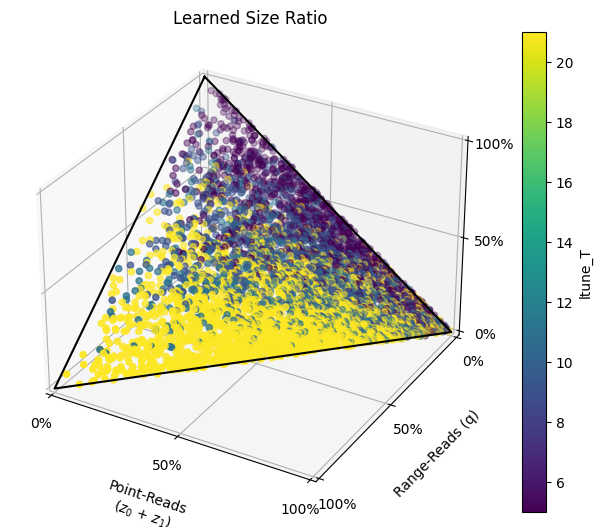

In [25]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
ax.set_title('Learned Size Ratio')
plt.show()

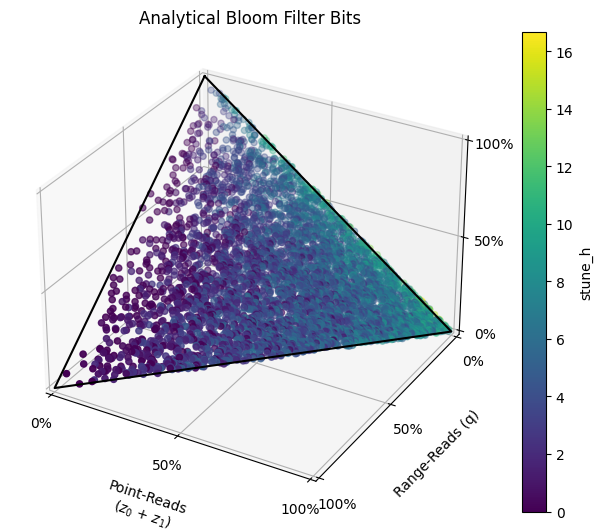

In [26]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

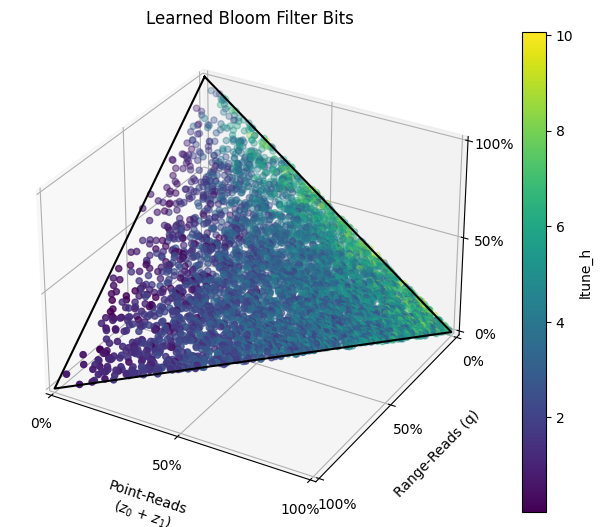

In [27]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

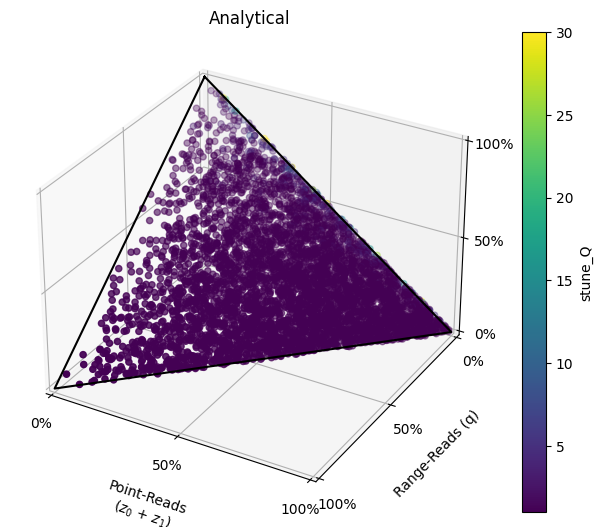

In [28]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_Q')
ax.set_title('Analytical')
plt.show()

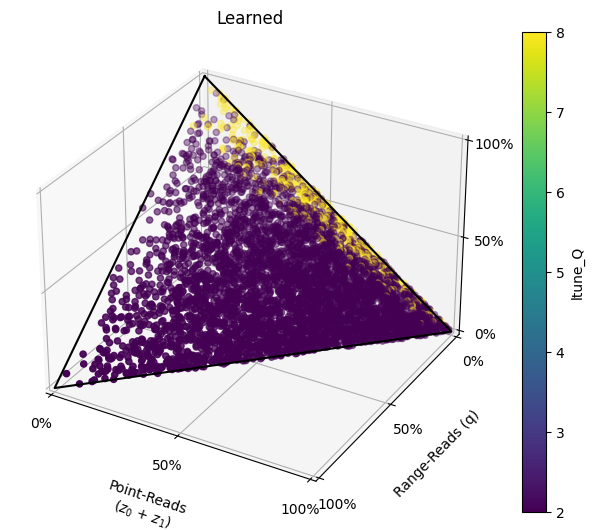

In [29]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_Q')
ax.set_title('Learned')
plt.show()

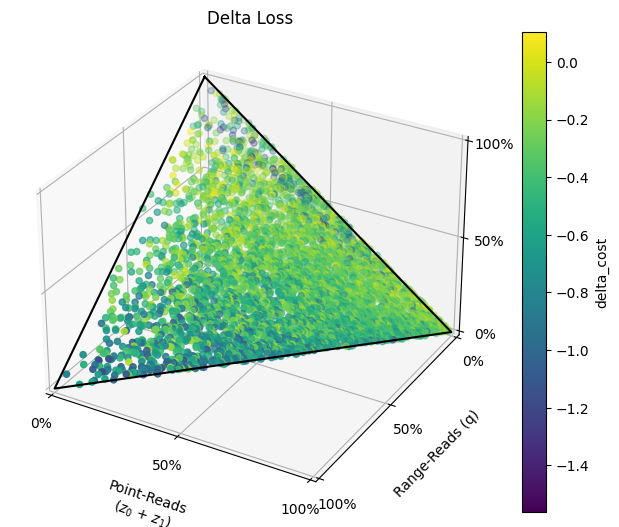

In [30]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='delta_cost')
ax.set_title('Delta Loss')
plt.show()

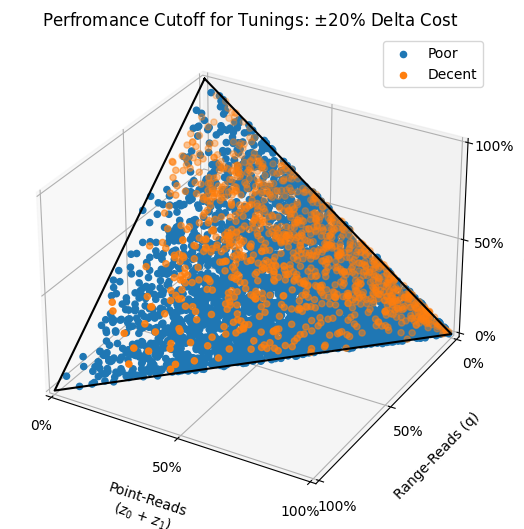

In [31]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (0.20)
groupa = table[(table['delta_cost'] > -cutoff) & (table['delta_cost'] < cutoff)]
groupb = table[(table['delta_cost'] < -cutoff) | (table['delta_cost'] > cutoff)]
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor', alpha=1)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent')
ax.set_title(f'Perfromance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend()
plt.show()

In [32]:
table

,z0,z1,q,w,B,s,E,H,N,stune_policy,...,ltune_T,ltune_Q,ltune_cost,ltune_loss,ltune_loss_direct,delta_cost,delta_loss,stune_diff,ltune_diff,ltune_mbuff
0,0.424,0.014,0.208,0.354,64.0,1.641769e-08,1024,17.869184,517693031,3,...,21,2,0.844525,0.929733,0.574588,-0.551755,-0.603865,-0.065127,-0.100895,0.807323
1,0.393,0.087,0.332,0.188,8.0,4.597387e-09,4096,10.751623,279207654,3,...,9,2,2.594250,2.667521,1.857067,-0.439338,-0.429616,-0.035237,-0.028244,0.211344
2,0.778,0.055,0.037,0.130,32.0,6.659778e-08,2048,14.722578,607843536,3,...,9,2,0.407960,0.499421,0.299223,-0.299221,-0.586231,-0.002689,-0.224193,0.510001
3,0.118,0.025,0.497,0.360,8.0,2.070984e-08,4096,12.807162,868281747,3,...,9,2,4.586892,4.365804,3.698174,-0.257315,-0.178925,-0.015088,0.048200,1.124061
4,0.186,0.031,0.520,0.263,4.0,4.833702e-08,8192,11.219929,162515875,3,...,9,2,5.526677,5.720492,4.749916,-0.204017,-0.225683,-0.016772,-0.035069,0.182755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.384,0.431,0.090,0.095,4.0,3.346289e-08,8192,9.988714,238024067,3,...,5,2,1.937615,1.885016,1.522228,-0.182144,-0.252597,0.081865,0.027146,0.134473
4996,0.493,0.227,0.054,0.226,32.0,1.643258e-08,2048,7.949271,724029682,3,...,9,2,0.809440,0.782501,0.553548,-0.225077,-0.387691,0.146564,0.033281,0.219520
4997,0.204,0.086,0.518,0.192,64.0,9.927115e-08,2048,11.720760,287079092,3,...,21,2,2.375607,2.443192,1.405121,-0.761724,-0.776333,-0.019991,-0.028449,0.302380
4998,0.069,0.044,0.855,0.032,32.0,7.939371e-08,2048,9.523554,393768038,3,...,21,2,4.105804,3.944072,2.370796,-0.751660,-0.408931,-0.194281,0.039391,0.378331


In [61]:
system = ltune_util.gen._sample_system()
z0, z1, q, w = ltune_util.gen._sample_workload(4)

In [62]:
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
out

tensor([[1.8732, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)

In [63]:
design = ltune_util.convert_ltune_output(out)
design

LSMDesign(h=1.8731931447982788, T=21, policy=<Policy.QFixed: 3>, Q=2, Y=1.0, Z=1.0, K=[])

In [64]:
loss = ltune_util.eval_lcm(design, system, z0, z1, q, w)
loss

2.530360221862793

In [65]:
loss_direct = ltune_util.eval_lcm_direct(out, system, z0, z1, q, w)
loss_direct

1.769059181213379